<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Other-information" data-toc-modified-id="Other-information-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Other information</a></span></li><li><span><a href="#Model-environment-set-up" data-toc-modified-id="Model-environment-set-up-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model environment set up</a></span><ul class="toc-item"><li><span><a href="#abiotic-factors:-solar,-temperature-cycles" data-toc-modified-id="abiotic-factors:-solar,-temperature-cycles-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>abiotic factors: solar, temperature cycles</a></span></li><li><span><a href="#ODE-model:-Generalised-Logistic" data-toc-modified-id="ODE-model:-Generalised-Logistic-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>ODE model: Generalised Logistic</a></span></li><li><span><a href="#default-parameters" data-toc-modified-id="default-parameters-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>default parameters</a></span></li><li><span><a href="#test-parameter-ranges" data-toc-modified-id="test-parameter-ranges-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>test parameter ranges</a></span></li></ul></li><li><span><a href="#Double-factors-test" data-toc-modified-id="Double-factors-test-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Double factors test</a></span><ul class="toc-item"><li><span><a href="#$r_p$-&amp;-$k_p$" data-toc-modified-id="$r_p$-&amp;-$k_p$-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>$r_p$ &amp; $k_p$</a></span></li><li><span><a href="#$r_p$-&amp;-$J_f|_p$" data-toc-modified-id="$r_p$-&amp;-$J_f|_p$-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>$r_p$ &amp; $J_f|_p$</a></span></li><li><span><a href="#$r_p$-&amp;-$T_p$" data-toc-modified-id="$r_p$-&amp;-$T_p$-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>$r_p$ &amp; $T_p$</a></span></li><li><span><a href="#$k_p$-&amp;-$J_f|_p$" data-toc-modified-id="$k_p$-&amp;-$J_f|_p$-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>$k_p$ &amp; $J_f|_p$</a></span></li><li><span><a href="#$k_p$-&amp;-$T_p$" data-toc-modified-id="$k_p$-&amp;-$T_p$-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>$k_p$ &amp; $T_p$</a></span></li><li><span><a href="#$J_f|_p$-&amp;-T_p" data-toc-modified-id="$J_f|_p$-&amp;-T_p-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>$J_f|_p$ &amp; T_p</a></span></li></ul></li></ul></div>

# Other information
[main notebook](https://nbviewer.jupyter.org/github/ph-u/Project/blob/master/meeting/MRes_02.ipynb)
|
[single Factor trial](https://nbviewer.jupyter.org/github/ph-u/Project/blob/master/meeting/MRes_02_sFac.ipynb)
# Model environment set up

In [1]:
using RCall, PyCall, Plots, ProgressMeter, DataFrames
mt = pyimport("math")
sc = pyimport("scipy")
itg = pyimport("scipy.integrate")
R"cbp<-c('#000000', '#E69F00', '#56B4E9', '#009E73', '#0072B2', '#D55E00', '#CC79A7', '#e79f00', '#9ad0f3', '#F0E442', '#999999', '#cccccc', '#6633ff', '#00FFCC', '#0066cc')"

RObject{StrSxp}
 [1] "#000000" "#E69F00" "#56B4E9" "#009E73" "#0072B2" "#D55E00" "#CC79A7"
 [8] "#e79f00" "#9ad0f3" "#F0E442" "#999999" "#cccccc" "#6633ff" "#00FFCC"
[15] "#0066cc"


## abiotic factors: solar, temperature cycles

In [2]:
function solar_dy(t, flux)
    S_dy = flux * mt.sin(2 * mt.pi / (24) * t)
    # add daily fluctuation (unit = hr)
    return (S_dy)
end
function solar_yr(t, flux)
    S_yr = flux * mt.sin(2 * mt.pi / (365.25 * 24) * t)
    # add seasonal fluctuation (unit = hr)
    return (S_yr)
end
function solar_sc(t, flux)
    S_sc = flux * mt.sin(2 * mt.pi / (11.8 * 365.25 * 24) * t)
    # add solar cycle fluctuation (unit = hr)
    return (S_sc)
end
function solar_al(t, base, f_sc, f_yr, f_dy)
    S_al = solar_sc(t, f_sc) + solar_yr(t, f_yr) + solar_dy(t, f_dy) + base
    ## three cycles additive effect
    return (S_al)
end

solar_al (generic function with 1 method)

## ODE model: Generalised Logistic
modified a bit in order also to plot solar cycle

In [3]:
function ebc_GLc(pops, t, Tk, TbS, TbT, CharP, CharQ)
    
    ## characteristics segregation
    p = pops[:1] # population of p
    q = pops[:2] # population of q
    rp=CharP[:1]+1; kp=CharP[:2]; Jfp=CharP[:3]; Tkp=CharP[:4]
    rq=CharQ[:1]+1; kq=CharQ[:2]; Jfq=CharQ[:3]; Tkq=CharQ[:4]
    
    ## abiotic factors
    SS = solar_al(t, TbS[:1], TbS[:2], TbS[:3], TbS[:4]) ## solar budget
    ST = solar_al(t, TbT[:1], TbT[:2], TbT[:3], TbT[:4]) ## temperature threat level
    
    ## energy budget
    Jp = SS*Jfp
    Jq = SS*Jfq
    # assume solar spectrum unchange throughout the day
    
    ## p & q filling up the space, so hpq + hqp = 1
    hpq = Jp*p/(Jp*p +Jq*q) # hindrance from q on p
    hqp = 1-hpq # hindrance from p on q
    
    ## thermal kill ratio
    if ST < Tk # assume if temperature lower than threshold, fixed ratio of population die
        TRp = Tkp
        TRq = TKq
    else
        TRp = 0
        TRq = 0
    end
    
    ## ODEs
    dpdt = p*(rp*kp -rp*p -rp*hpq*q -TRp) # +growth*carrying -intra-competition -hinder by q -thermal stress (when applicable)
    dqdt = q*(rq*kq -rq*q -rq*hqp*p -TRq) # +growth*carrying -intra-competition -hinder by p -thermal stress (when applicable)
    
    return (dpdt, dqdt, SS-TbS[:1]+.5)
end

ebc_GLc (generic function with 1 method)

## default parameters

In [4]:
## unknown reason, must reload for every simulation
pops = sc.array([.5, .3, 0]) # initial population p, q

t = sc.linspace(0, 10, 10000) # time series (hours)

Tk = 5 # thermal kill activation threshold

TbS = sc.array([1500, 1, 100, 30]) # solar: mean per unit time energy, solar cycle amplitude, annual amplitude, daily amplitude

TbT = sc.array([15, 0, 10, 3]) # temperature: mean per unit time, solar cycle amplitude, annual amplitude, daily amplitude

CharP = sc.array([.04, .7, .3, .1]) # p characteristics: net growth rate, carrying cap ratio, energy extraction fraction, thermal sensitive fraction

CharQ = sc.array([.04, .7, .3, .1]) # q characteristics: net growth rate, carrying cap ratio, energy extraction fraction, thermal sensitive fraction

println()

## test parameter ranges

In [5]:
## parameter test trial dump
ppdef = [.9, .8, .7, .6, .5, .4, .3, .2, .1]
rpdef = [.07, .06, .05, .04, .03, .02, .01]
kpdef = [1., .9, .8, .7, .6, .5, .4]
jpdef = [.7, .6, .4, .3, .2, .1, .05]
tpdef = [.6, .5, .3, .1, .05, .02, .01]

println()

# Double factors test

## $r_p$ & $k_p$

In [6]:
## unknown reason, must reload for every simulation
pops = sc.array([.5, .3, 0]) # initial population p, q

t = sc.linspace(0, 10, 10000) # time series (hours)

Tk = 5 # thermal kill activation threshold

TbS = sc.array([1500, 1, 100, 30]) # solar: mean per unit time energy, solar cycle amplitude, annual amplitude, daily amplitude

TbT = sc.array([15, 0, 10, 3]) # temperature: mean per unit time, solar cycle amplitude, annual amplitude, daily amplitude

CharP = sc.array([.04, .7, .3, .1]) # p characteristics: net growth rate, carrying cap ratio, energy extraction fraction, thermal sensitive fraction

CharQ = sc.array([.04, .7, .3, .1]) # q characteristics: net growth rate, carrying cap ratio, energy extraction fraction, thermal sensitive fraction

println()

┌ Info: Saved animation to 
│   fn = /Volumes/HPM-000/Academic/Masters/ICL_CMEE/Project/meeting/simResult/sim_rkP.gif
└ @ Plots /Users/Ho_Pok_Man/.julia/packages/Plots/qZHsp/src/animation.jl:98


Plots.AnimatedGif("/Volumes/HPM-000/Academic/Masters/ICL_CMEE/Project/meeting/simResult/sim_rkP.gif")
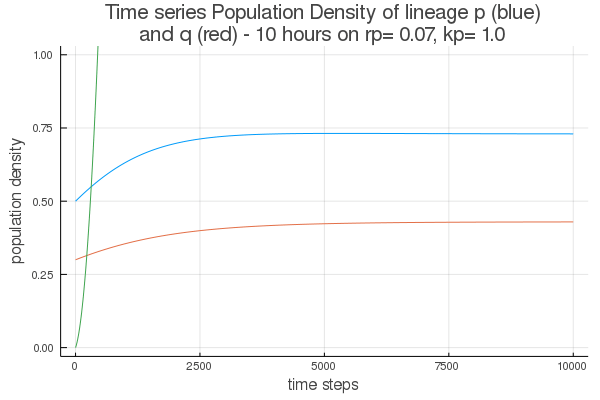

In [7]:
t = sc.linspace(0, 10, 10000) # time series (hours)

test1 = rpdef
test2 = kpdef
aa = @animate for i in 1:length(test1)
    CharP = sc.array([test1[i], test2[i], .3, .1])
    
    pops = sc.array([.5, .3, 0]) # unknown reason can't put it out of loop
    pops, infodict = itg.odeint(ebc_GLc, pops, t, full_output=true, args=(Tk, TbS, TbT, CharP, CharQ))
    plot(pops, xlabel="time steps", ylabel="population density", title="Time series Population Density of lineage p (blue)\nand q (red) - 10 hours on rp= "*string(test1[i])*", kp= "*string(test2[i]), label="", ylim=[0,1])

end
gif(aa, "simResult/sim_rkP.gif", fps=1)

In [8]:
## unknown reason, must reload for every simulation
pops = sc.array([.5, .3, 0]) # initial population p, q

t = sc.linspace(0, 10, 10000) # time series (hours)

Tk = 5 # thermal kill activation threshold

TbS = sc.array([1500, 1, 100, 30]) # solar: mean per unit time energy, solar cycle amplitude, annual amplitude, daily amplitude

TbT = sc.array([15, 0, 10, 3]) # temperature: mean per unit time, solar cycle amplitude, annual amplitude, daily amplitude

CharP = sc.array([.04, .7, .3, .1]) # p characteristics: net growth rate, carrying cap ratio, energy extraction fraction, thermal sensitive fraction

CharQ = sc.array([.04, .7, .3, .1]) # q characteristics: net growth rate, carrying cap ratio, energy extraction fraction, thermal sensitive fraction

println()

┌ Info: Saved animation to 
│   fn = /Volumes/HPM-000/Academic/Masters/ICL_CMEE/Project/meeting/simResult/sim_rkN.gif
└ @ Plots /Users/Ho_Pok_Man/.julia/packages/Plots/qZHsp/src/animation.jl:98


Plots.AnimatedGif("/Volumes/HPM-000/Academic/Masters/ICL_CMEE/Project/meeting/simResult/sim_rkN.gif")
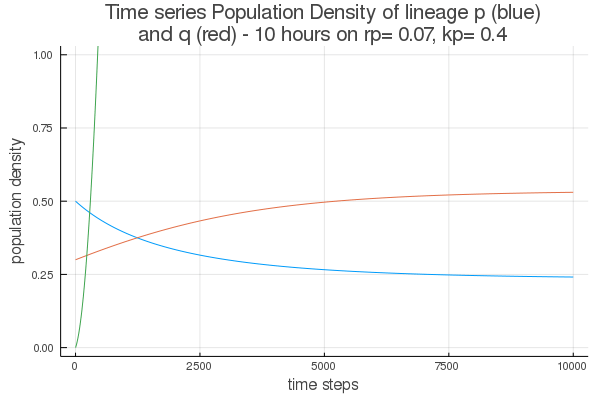

In [9]:
t = sc.linspace(0, 10, 10000) # time series (hours)

test1 = rpdef
test2 = reverse(kpdef)
aa = @animate for i in 1:length(test1)
    CharP = sc.array([test1[i], test2[i], .3, .1])
    
    pops = sc.array([.5, .3, 0]) # unknown reason can't put it out of loop
    pops, infodict = itg.odeint(ebc_GLc, pops, t, full_output=true, args=(Tk, TbS, TbT, CharP, CharQ))
    plot(pops, xlabel="time steps", ylabel="population density", title="Time series Population Density of lineage p (blue)\nand q (red) - 10 hours on rp= "*string(test1[i])*", kp= "*string(test2[i]), label="", ylim=[0,1])

end
gif(aa, "simResult/sim_rkN.gif", fps=1)

## $r_p$ & $J_f|_p$

In [10]:
## unknown reason, must reload for every simulation
pops = sc.array([.5, .3, 0]) # initial population p, q

t = sc.linspace(0, 10, 10000) # time series (hours)

Tk = 5 # thermal kill activation threshold

TbS = sc.array([1500, 1, 100, 30]) # solar: mean per unit time energy, solar cycle amplitude, annual amplitude, daily amplitude

TbT = sc.array([15, 0, 10, 3]) # temperature: mean per unit time, solar cycle amplitude, annual amplitude, daily amplitude

CharP = sc.array([.04, .7, .3, .1]) # p characteristics: net growth rate, carrying cap ratio, energy extraction fraction, thermal sensitive fraction

CharQ = sc.array([.04, .7, .3, .1]) # q characteristics: net growth rate, carrying cap ratio, energy extraction fraction, thermal sensitive fraction

println()

┌ Info: Saved animation to 
│   fn = /Volumes/HPM-000/Academic/Masters/ICL_CMEE/Project/meeting/simResult/sim_rjP.gif
└ @ Plots /Users/Ho_Pok_Man/.julia/packages/Plots/qZHsp/src/animation.jl:98


Plots.AnimatedGif("/Volumes/HPM-000/Academic/Masters/ICL_CMEE/Project/meeting/simResult/sim_rjP.gif")
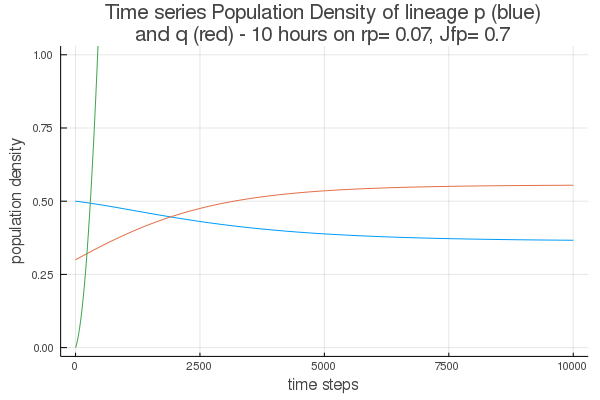

In [11]:
t = sc.linspace(0, 10, 10000) # time series (hours)

test1 = rpdef
test2 = jpdef
aa = @animate for i in 1:length(test1)
    CharP = sc.array([test1[i], .7, test2[i], .1])
    
    pops = sc.array([.5, .3, 0]) # unknown reason can't put it out of loop
    pops, infodict = itg.odeint(ebc_GLc, pops, t, full_output=true, args=(Tk, TbS, TbT, CharP, CharQ))
    plot(pops, xlabel="time steps", ylabel="population density", title="Time series Population Density of lineage p (blue)\nand q (red) - 10 hours on rp= "*string(test1[i])*", Jfp= "*string(test2[i]), label="", ylim=[0,1])

end
gif(aa, "simResult/sim_rjP.gif", fps=1)

In [12]:
## unknown reason, must reload for every simulation
pops = sc.array([.5, .3, 0]) # initial population p, q

t = sc.linspace(0, 10, 10000) # time series (hours)

Tk = 5 # thermal kill activation threshold

TbS = sc.array([1500, 1, 100, 30]) # solar: mean per unit time energy, solar cycle amplitude, annual amplitude, daily amplitude

TbT = sc.array([15, 0, 10, 3]) # temperature: mean per unit time, solar cycle amplitude, annual amplitude, daily amplitude

CharP = sc.array([.04, .7, .3, .1]) # p characteristics: net growth rate, carrying cap ratio, energy extraction fraction, thermal sensitive fraction

CharQ = sc.array([.04, .7, .3, .1]) # q characteristics: net growth rate, carrying cap ratio, energy extraction fraction, thermal sensitive fraction

println()

┌ Info: Saved animation to 
│   fn = /Volumes/HPM-000/Academic/Masters/ICL_CMEE/Project/meeting/simResult/sim_rjN.gif
└ @ Plots /Users/Ho_Pok_Man/.julia/packages/Plots/qZHsp/src/animation.jl:98


Plots.AnimatedGif("/Volumes/HPM-000/Academic/Masters/ICL_CMEE/Project/meeting/simResult/sim_rjN.gif")
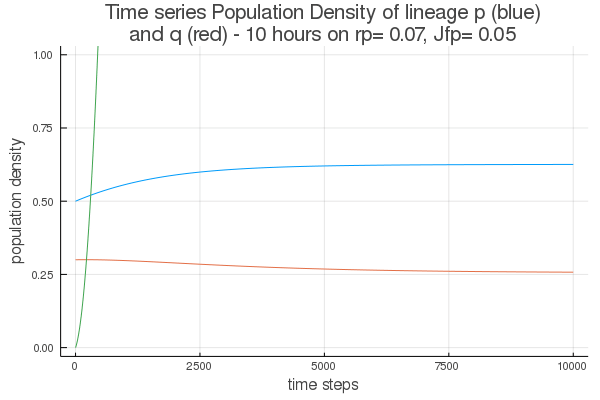

In [13]:
t = sc.linspace(0, 10, 10000) # time series (hours)

test1 = rpdef
test2 = reverse(jpdef)
aa = @animate for i in 1:length(test1)
    CharP = sc.array([test1[i], .7, test2[i], .1])
    
    pops = sc.array([.5, .3, 0]) # unknown reason can't put it out of loop
    pops, infodict = itg.odeint(ebc_GLc, pops, t, full_output=true, args=(Tk, TbS, TbT, CharP, CharQ))
    plot(pops, xlabel="time steps", ylabel="population density", title="Time series Population Density of lineage p (blue)\nand q (red) - 10 hours on rp= "*string(test1[i])*", Jfp= "*string(test2[i]), label="", ylim=[0,1])

end
gif(aa, "simResult/sim_rjN.gif", fps=1)

## $r_p$ & $T_p$

In [14]:
## unknown reason, must reload for every simulation
pops = sc.array([.5, .3, 0]) # initial population p, q

t = sc.linspace(0, 10, 10000) # time series (hours)

Tk = 5 # thermal kill activation threshold

TbS = sc.array([1500, 1, 100, 30]) # solar: mean per unit time energy, solar cycle amplitude, annual amplitude, daily amplitude

TbT = sc.array([15, 0, 10, 3]) # temperature: mean per unit time, solar cycle amplitude, annual amplitude, daily amplitude

CharP = sc.array([.04, .7, .3, .1]) # p characteristics: net growth rate, carrying cap ratio, energy extraction fraction, thermal sensitive fraction

CharQ = sc.array([.04, .7, .3, .1]) # q characteristics: net growth rate, carrying cap ratio, energy extraction fraction, thermal sensitive fraction

println()

┌ Info: Saved animation to 
│   fn = /Volumes/HPM-000/Academic/Masters/ICL_CMEE/Project/meeting/simResult/sim_rtP.gif
└ @ Plots /Users/Ho_Pok_Man/.julia/packages/Plots/qZHsp/src/animation.jl:98


Plots.AnimatedGif("/Volumes/HPM-000/Academic/Masters/ICL_CMEE/Project/meeting/simResult/sim_rtP.gif")
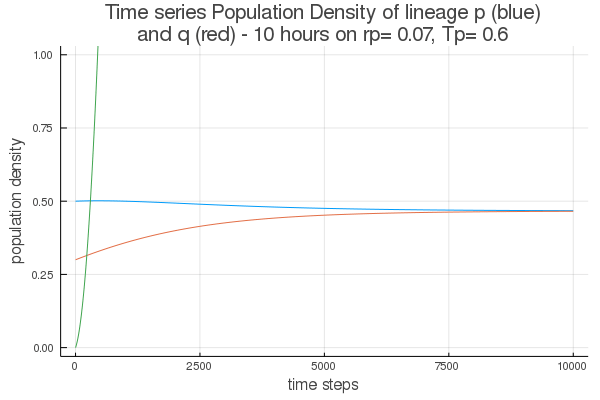

In [15]:
t = sc.linspace(0, 10, 10000) # time series (hours)
Tk=14

test1 = rpdef
test2 = tpdef
aa = @animate for i in 1:length(test1)
    CharP = sc.array([test1[i], .7, .3, test2[i]])
    
    pops = sc.array([.5, .3, 0]) # unknown reason can't put it out of loop
    pops, infodict = itg.odeint(ebc_GLc, pops, t, full_output=true, args=(Tk, TbS, TbT, CharP, CharQ))
    plot(pops, xlabel="time steps", ylabel="population density", title="Time series Population Density of lineage p (blue)\nand q (red) - 10 hours on rp= "*string(test1[i])*", Tp= "*string(test2[i]), label="", ylim=[0,1])

end
gif(aa, "simResult/sim_rtP.gif", fps=1)

In [16]:
## unknown reason, must reload for every simulation
pops = sc.array([.5, .3, 0]) # initial population p, q

t = sc.linspace(0, 10, 10000) # time series (hours)

Tk = 5 # thermal kill activation threshold

TbS = sc.array([1500, 1, 100, 30]) # solar: mean per unit time energy, solar cycle amplitude, annual amplitude, daily amplitude

TbT = sc.array([15, 0, 10, 3]) # temperature: mean per unit time, solar cycle amplitude, annual amplitude, daily amplitude

CharP = sc.array([.04, .7, .3, .1]) # p characteristics: net growth rate, carrying cap ratio, energy extraction fraction, thermal sensitive fraction

CharQ = sc.array([.04, .7, .3, .1]) # q characteristics: net growth rate, carrying cap ratio, energy extraction fraction, thermal sensitive fraction

println()

┌ Info: Saved animation to 
│   fn = /Volumes/HPM-000/Academic/Masters/ICL_CMEE/Project/meeting/simResult/sim_rtN.gif
└ @ Plots /Users/Ho_Pok_Man/.julia/packages/Plots/qZHsp/src/animation.jl:98


Plots.AnimatedGif("/Volumes/HPM-000/Academic/Masters/ICL_CMEE/Project/meeting/simResult/sim_rtN.gif")
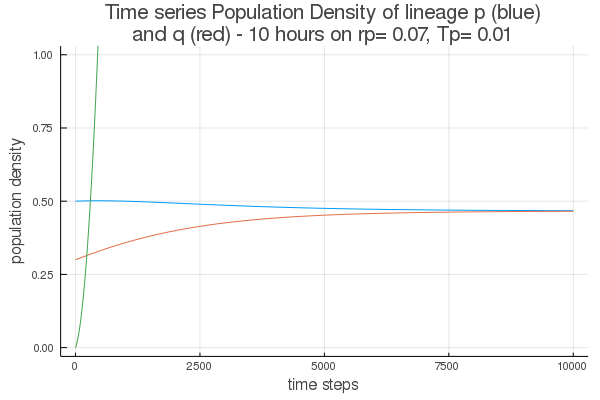

In [17]:
t = sc.linspace(0, 10, 10000) # time series (hours)
Tk=14

test1 = rpdef
test2 = reverse(tpdef)
aa = @animate for i in 1:length(test1)
    CharP = sc.array([test1[i], .7, .3, test2[i]])
    
    pops = sc.array([.5, .3, 0]) # unknown reason can't put it out of loop
    pops, infodict = itg.odeint(ebc_GLc, pops, t, full_output=true, args=(Tk, TbS, TbT, CharP, CharQ))
    plot(pops, xlabel="time steps", ylabel="population density", title="Time series Population Density of lineage p (blue)\nand q (red) - 10 hours on rp= "*string(test1[i])*", Tp= "*string(test2[i]), label="", ylim=[0,1])

end
gif(aa, "simResult/sim_rtN.gif", fps=1)

## $k_p$ & $J_f|_p$

In [18]:
## unknown reason, must reload for every simulation
pops = sc.array([.5, .3, 0]) # initial population p, q

t = sc.linspace(0, 10, 10000) # time series (hours)

Tk = 5 # thermal kill activation threshold

TbS = sc.array([1500, 1, 100, 30]) # solar: mean per unit time energy, solar cycle amplitude, annual amplitude, daily amplitude

TbT = sc.array([15, 0, 10, 3]) # temperature: mean per unit time, solar cycle amplitude, annual amplitude, daily amplitude

CharP = sc.array([.04, .7, .3, .1]) # p characteristics: net growth rate, carrying cap ratio, energy extraction fraction, thermal sensitive fraction

CharQ = sc.array([.04, .7, .3, .1]) # q characteristics: net growth rate, carrying cap ratio, energy extraction fraction, thermal sensitive fraction

println()

┌ Info: Saved animation to 
│   fn = /Volumes/HPM-000/Academic/Masters/ICL_CMEE/Project/meeting/simResult/sim_kjP.gif
└ @ Plots /Users/Ho_Pok_Man/.julia/packages/Plots/qZHsp/src/animation.jl:98


Plots.AnimatedGif("/Volumes/HPM-000/Academic/Masters/ICL_CMEE/Project/meeting/simResult/sim_kjP.gif")
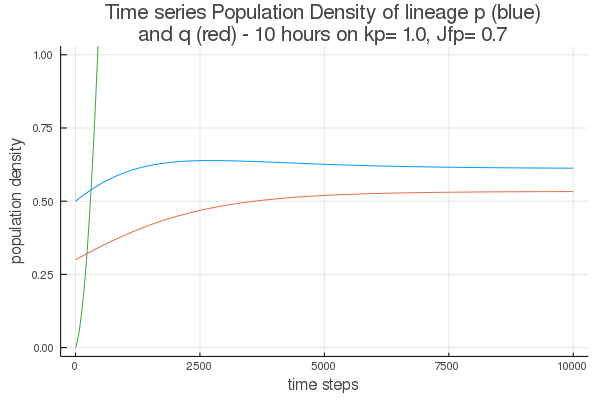

In [19]:
t = sc.linspace(0, 10, 10000) # time series (hours)

test1 = kpdef
test2 = jpdef
aa = @animate for i in 1:length(test1)
    CharP = sc.array([.04, test1[i], test2[i], .1])
    
    pops = sc.array([.5, .3, 0]) # unknown reason can't put it out of loop
    pops, infodict = itg.odeint(ebc_GLc, pops, t, full_output=true, args=(Tk, TbS, TbT, CharP, CharQ))
    plot(pops, xlabel="time steps", ylabel="population density", title="Time series Population Density of lineage p (blue)\nand q (red) - 10 hours on kp= "*string(test1[i])*", Jfp= "*string(test2[i]), label="", ylim=[0,1])

end
gif(aa, "simResult/sim_kjP.gif", fps=1)

In [20]:
## unknown reason, must reload for every simulation
pops = sc.array([.5, .3, 0]) # initial population p, q

t = sc.linspace(0, 10, 10000) # time series (hours)

Tk = 5 # thermal kill activation threshold

TbS = sc.array([1500, 1, 100, 30]) # solar: mean per unit time energy, solar cycle amplitude, annual amplitude, daily amplitude

TbT = sc.array([15, 0, 10, 3]) # temperature: mean per unit time, solar cycle amplitude, annual amplitude, daily amplitude

CharP = sc.array([.04, .7, .3, .1]) # p characteristics: net growth rate, carrying cap ratio, energy extraction fraction, thermal sensitive fraction

CharQ = sc.array([.04, .7, .3, .1]) # q characteristics: net growth rate, carrying cap ratio, energy extraction fraction, thermal sensitive fraction

println()

┌ Info: Saved animation to 
│   fn = /Volumes/HPM-000/Academic/Masters/ICL_CMEE/Project/meeting/simResult/sim_kjN.gif
└ @ Plots /Users/Ho_Pok_Man/.julia/packages/Plots/qZHsp/src/animation.jl:98


Plots.AnimatedGif("/Volumes/HPM-000/Academic/Masters/ICL_CMEE/Project/meeting/simResult/sim_kjN.gif")
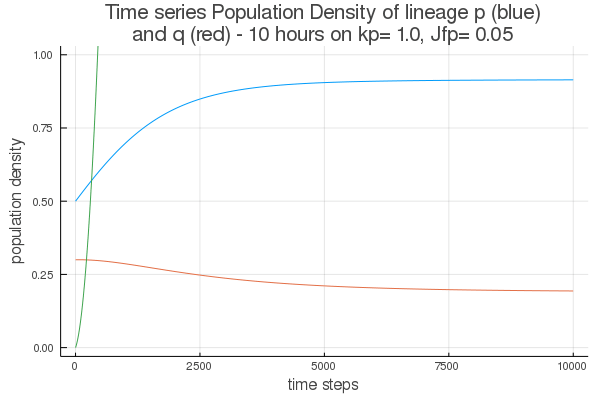

In [21]:
t = sc.linspace(0, 10, 10000) # time series (hours)

test1 = kpdef
test2 = reverse(jpdef)
aa = @animate for i in 1:length(test1)
    CharP = sc.array([.04, test1[i], test2[i], .1])
    
    pops = sc.array([.5, .3, 0]) # unknown reason can't put it out of loop
    pops, infodict = itg.odeint(ebc_GLc, pops, t, full_output=true, args=(Tk, TbS, TbT, CharP, CharQ))
    plot(pops, xlabel="time steps", ylabel="population density", title="Time series Population Density of lineage p (blue)\nand q (red) - 10 hours on kp= "*string(test1[i])*", Jfp= "*string(test2[i]), label="", ylim=[0,1])

end
gif(aa, "simResult/sim_kjN.gif", fps=1)

## $k_p$ & $T_p$

In [22]:
## unknown reason, must reload for every simulation
pops = sc.array([.5, .3, 0]) # initial population p, q

t = sc.linspace(0, 10, 10000) # time series (hours)

Tk = 5 # thermal kill activation threshold

TbS = sc.array([1500, 1, 100, 30]) # solar: mean per unit time energy, solar cycle amplitude, annual amplitude, daily amplitude

TbT = sc.array([15, 0, 10, 3]) # temperature: mean per unit time, solar cycle amplitude, annual amplitude, daily amplitude

CharP = sc.array([.04, .7, .3, .1]) # p characteristics: net growth rate, carrying cap ratio, energy extraction fraction, thermal sensitive fraction

CharQ = sc.array([.04, .7, .3, .1]) # q characteristics: net growth rate, carrying cap ratio, energy extraction fraction, thermal sensitive fraction

println()

┌ Info: Saved animation to 
│   fn = /Volumes/HPM-000/Academic/Masters/ICL_CMEE/Project/meeting/simResult/sim_ktP.gif
└ @ Plots /Users/Ho_Pok_Man/.julia/packages/Plots/qZHsp/src/animation.jl:98


Plots.AnimatedGif("/Volumes/HPM-000/Academic/Masters/ICL_CMEE/Project/meeting/simResult/sim_ktP.gif")
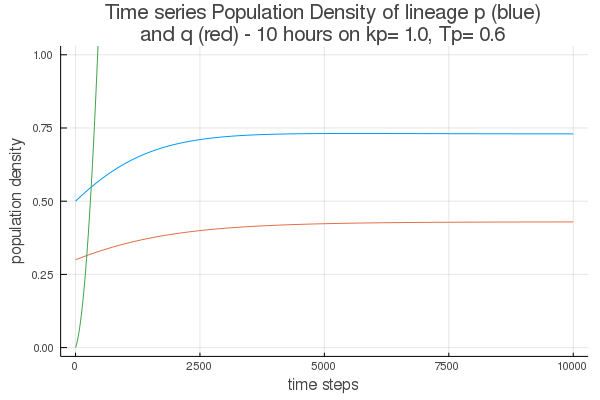

In [23]:
t = sc.linspace(0, 10, 10000) # time series (hours)
Tk=14

test1 = kpdef
test2 = tpdef
aa = @animate for i in 1:length(test1)
    CharP = sc.array([.04, test1[i], .3, test2[i]])
    
    pops = sc.array([.5, .3, 0]) # unknown reason can't put it out of loop
    pops, infodict = itg.odeint(ebc_GLc, pops, t, full_output=true, args=(Tk, TbS, TbT, CharP, CharQ))
    plot(pops, xlabel="time steps", ylabel="population density", title="Time series Population Density of lineage p (blue)\nand q (red) - 10 hours on kp= "*string(test1[i])*", Tp= "*string(test2[i]), label="", ylim=[0,1])

end
gif(aa, "simResult/sim_ktP.gif", fps=1)

In [24]:
## unknown reason, must reload for every simulation
pops = sc.array([.5, .3, 0]) # initial population p, q

t = sc.linspace(0, 10, 10000) # time series (hours)

Tk = 5 # thermal kill activation threshold

TbS = sc.array([1500, 1, 100, 30]) # solar: mean per unit time energy, solar cycle amplitude, annual amplitude, daily amplitude

TbT = sc.array([15, 0, 10, 3]) # temperature: mean per unit time, solar cycle amplitude, annual amplitude, daily amplitude

CharP = sc.array([.04, .7, .3, .1]) # p characteristics: net growth rate, carrying cap ratio, energy extraction fraction, thermal sensitive fraction

CharQ = sc.array([.04, .7, .3, .1]) # q characteristics: net growth rate, carrying cap ratio, energy extraction fraction, thermal sensitive fraction

println()

┌ Info: Saved animation to 
│   fn = /Volumes/HPM-000/Academic/Masters/ICL_CMEE/Project/meeting/simResult/sim_ktN.gif
└ @ Plots /Users/Ho_Pok_Man/.julia/packages/Plots/qZHsp/src/animation.jl:98


Plots.AnimatedGif("/Volumes/HPM-000/Academic/Masters/ICL_CMEE/Project/meeting/simResult/sim_ktN.gif")
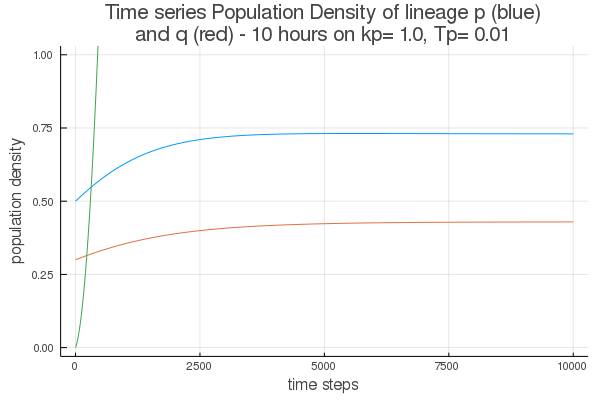

In [25]:
t = sc.linspace(0, 10, 10000) # time series (hours)
Tk=14

test1 = kpdef
test2 = reverse(tpdef)
aa = @animate for i in 1:length(test1)
    CharP = sc.array([.04, test1[i], .3, test2[i]])
    
    pops = sc.array([.5, .3, 0]) # unknown reason can't put it out of loop
    pops, infodict = itg.odeint(ebc_GLc, pops, t, full_output=true, args=(Tk, TbS, TbT, CharP, CharQ))
    plot(pops, xlabel="time steps", ylabel="population density", title="Time series Population Density of lineage p (blue)\nand q (red) - 10 hours on kp= "*string(test1[i])*", Tp= "*string(test2[i]), label="", ylim=[0,1])

end
gif(aa, "simResult/sim_ktN.gif", fps=1)

## $J_f|_p$ & T_p

In [26]:
## unknown reason, must reload for every simulation
pops = sc.array([.5, .3, 0]) # initial population p, q

t = sc.linspace(0, 10, 10000) # time series (hours)

Tk = 5 # thermal kill activation threshold

TbS = sc.array([1500, 1, 100, 30]) # solar: mean per unit time energy, solar cycle amplitude, annual amplitude, daily amplitude

TbT = sc.array([15, 0, 10, 3]) # temperature: mean per unit time, solar cycle amplitude, annual amplitude, daily amplitude

CharP = sc.array([.04, .7, .3, .1]) # p characteristics: net growth rate, carrying cap ratio, energy extraction fraction, thermal sensitive fraction

CharQ = sc.array([.04, .7, .3, .1]) # q characteristics: net growth rate, carrying cap ratio, energy extraction fraction, thermal sensitive fraction

println()

┌ Info: Saved animation to 
│   fn = /Volumes/HPM-000/Academic/Masters/ICL_CMEE/Project/meeting/simResult/sim_jtP.gif
└ @ Plots /Users/Ho_Pok_Man/.julia/packages/Plots/qZHsp/src/animation.jl:98


Plots.AnimatedGif("/Volumes/HPM-000/Academic/Masters/ICL_CMEE/Project/meeting/simResult/sim_jtP.gif")
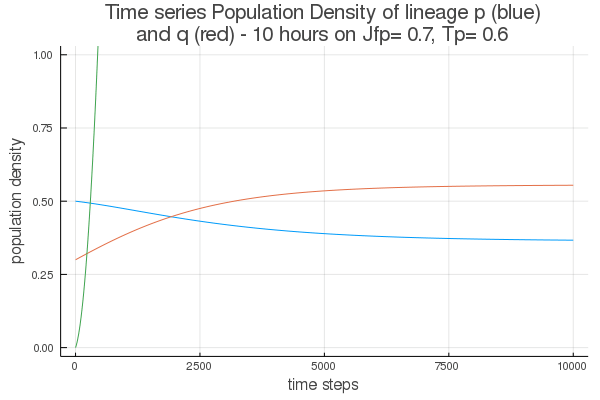

In [27]:
t = sc.linspace(0, 10, 10000) # time series (hours)
Tk=14

test1 = jpdef
test2 = tpdef
aa = @animate for i in 1:length(test1)
    CharP = sc.array([.04, .7, test1[i], test2[i]])
    
    pops = sc.array([.5, .3, 0]) # unknown reason can't put it out of loop
    pops, infodict = itg.odeint(ebc_GLc, pops, t, full_output=true, args=(Tk, TbS, TbT, CharP, CharQ))
    plot(pops, xlabel="time steps", ylabel="population density", title="Time series Population Density of lineage p (blue)\nand q (red) - 10 hours on Jfp= "*string(test1[i])*", Tp= "*string(test2[i]), label="", ylim=[0,1])

end
gif(aa, "simResult/sim_jtP.gif", fps=1)

In [28]:
## unknown reason, must reload for every simulation
pops = sc.array([.5, .3, 0]) # initial population p, q

t = sc.linspace(0, 10, 10000) # time series (hours)

Tk = 5 # thermal kill activation threshold

TbS = sc.array([1500, 1, 100, 30]) # solar: mean per unit time energy, solar cycle amplitude, annual amplitude, daily amplitude

TbT = sc.array([15, 0, 10, 3]) # temperature: mean per unit time, solar cycle amplitude, annual amplitude, daily amplitude

CharP = sc.array([.04, .7, .3, .1]) # p characteristics: net growth rate, carrying cap ratio, energy extraction fraction, thermal sensitive fraction

CharQ = sc.array([.04, .7, .3, .1]) # q characteristics: net growth rate, carrying cap ratio, energy extraction fraction, thermal sensitive fraction

println()

┌ Info: Saved animation to 
│   fn = /Volumes/HPM-000/Academic/Masters/ICL_CMEE/Project/meeting/simResult/sim_jtN.gif
└ @ Plots /Users/Ho_Pok_Man/.julia/packages/Plots/qZHsp/src/animation.jl:98


Plots.AnimatedGif("/Volumes/HPM-000/Academic/Masters/ICL_CMEE/Project/meeting/simResult/sim_jtN.gif")
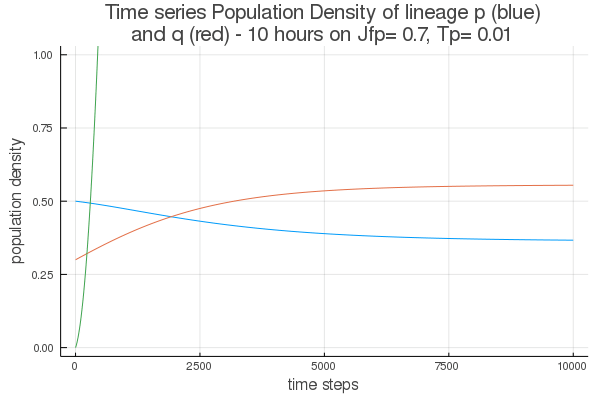

In [29]:
t = sc.linspace(0, 10, 10000) # time series (hours)
Tk=14

test1 = jpdef
test2 = reverse(tpdef)
aa = @animate for i in 1:length(test1)
    CharP = sc.array([.04, .7, test1[i], test2[i]])
    
    pops = sc.array([.5, .3, 0]) # unknown reason can't put it out of loop
    pops, infodict = itg.odeint(ebc_GLc, pops, t, full_output=true, args=(Tk, TbS, TbT, CharP, CharQ))
    plot(pops, xlabel="time steps", ylabel="population density", title="Time series Population Density of lineage p (blue)\nand q (red) - 10 hours on Jfp= "*string(test1[i])*", Tp= "*string(test2[i]), label="", ylim=[0,1])

end
gif(aa, "simResult/sim_jtN.gif", fps=1)